This script accesses the MIMIC database and extracts sub-tables for use in defining the final septic patient cohort in the [next step](https://colab.research.google.com/drive/1txkCiCsdXZ4wKlkV2yjePUq_nbuXjcVN?usp=chrome_ntp#scrollTo=LXoZFtcTGLYb&uniqifier=1).

sub-tables:
* trum_demog: Trauma Demographics (with truma population ids `trum_ids_df`)
* cx: Culture
* abx (Antibiotics administration)


**Resference**:

* This is a pure-python implementation based on a corrected version of the original R repo accompanying ["Defining Posttraumatic Sepsis for Population-Level Research"](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2800552) for MIMIC Dataset

* It is also sourced and modified from: [Microsoft mimic_sepsis](https://github.com/microsoft/mimic_sepsis/tree/main)


**Notes**:

This notebook assumes you have access to MIMIC III (v1.4) on Google BigQuery.
> - To get access for MIMIC III(v1.4) follow [link](https://physionet.org/content/mimiciii/1.4/)
> - To set up MIMIC data on Google BigQuery, follow [link](https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/)
> - To access MIMIC data in Google Colab, check the [link](https://colab.research.google.com/drive/1REu-ofzNzqsTT1cxLHIegPB0nGmwKaM0?usp=sharing#scrollTo=s-MoFA6NkkbZ)

# Set up

In [5]:
# import gzip
import os
# import re
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# cd to code folder
%cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project
import mimic_utils as utils
import mimiciii_icu_trauma_patient_cohort as trauma_cohort

# Project Path
PROJECT_PATH = '/content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project'
# Data Path
# mimic original dataset path
DATASET_PATH = os.path.join(PROJECT_PATH, '1.4')
PREPROCESS_DATA_PATH = os.path.join(PROJECT_PATH, 'preprocess')

# environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3'  #this need to change according to your project_id in BigQuery

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project


## halper fun

In [6]:
def assign_icustay_id(row, icustay_df, time_column='charttime'):
  """
  this function fill missing icustay_id(NA/NaN values) according to ICUSTAYS.csv.gz table
    icu_stay: load from ICUSTAYS.csv.gz
    df: the row Series that needed to fillin icustay_id (the columns in this table should be all lowercase)
    time_column: the time column that used to identify
  """
  row[time_column] = pd.to_datetime(row[time_column])
  # generate missing icustay_id
  if ('icustay_id' not in row.index) or (pd.isna(row.icustay_id)):
    # extract all icustay for a given subject_id
    icustay = icustay_df[icustay_df.SUBJECT_ID == row.subject_id]
    # check if with in duration
    target_id = icustay.loc[(icustay['INTIME'] <= row[time_column]) & (row[time_column] <= icustay['OUTTIME'])].ICUSTAY_ID
    # print(target_id)
    if target_id.shape[0] == 1: # if in one duration
      return target_id.values[0]
    elif target_id.shape[0] > 1:
      print("ERROR1: one charttime matching with multi icu duration", row)
      return 'ERROR1'

    # if not in aby duration, then check if in same day as intime date
    # ""--  we allow 24 hours before ICU admission (to grab labs before admit)"" from MIT-LCP icustay_hours.sql
    target_id = icustay[icustay['INTIME'].dt.date == row[time_column].date()].ICUSTAY_ID
    if target_id.shape[0] == 1: # if at one stare date
      return target_id.values[0]
    elif target_id.shape[0] > 1:
      print("ERROR2: one charttime matching with multi icu intime date", row)
      return 'ERROR2'
    return np.nan # not match
  else: # if not missing, use the original icustay_id
    return row.icustay_id

# Trauma Demographics

* trum_ids_df: hadm_id for Trauma Population
* trum_demog:
> culumns:
> * IDs: 'hadm_id',
> * Tims/duration: 'adm_date', 'admittime', 'dischtime', 'los_hospital_hours',
> * Outhers: 'hospital_expire_flag'

In [ ]:
import mimiciii_icu_trauma_patient_cohort as TraumaCohort # for trauma cohort

# Select Trauma Population (IDs)
TRUM_df = trauma_cohort.trum_population_ids(
    DATASET_PATH, PREPROCESS_DATA_PATH, #local path: mimiciii dataset
    PROJECT_ID,                         #mimiciii dataset: bigquery id
    is_report=True)
#This table should contain 1 row per patient (with unique hadm_id)
trum_ids_df = TRUM_df[['hadm_id']].drop_duplicates() # we only need Hosipital Admission ID

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimiciii_icu_trauma_patient_cohort.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trum_df.loc[:, "ICD9_CODE"] = trum_df.loc[:, "ICD9_CODE"].apply(lambda e: str(e)+"0" if len(str(e)) < 5 else e)


            TOTAL  TRUM basic filter  TRUM Vent filter
subject_id  46428               4826              1551
hadm_id     57328               4977              1570
icustay_id  61051               5410              1828


In [ ]:
#####################################################################

#Trauma Demographics
# This table(demog_df) should contain 1 row per patient with unique hadm_id
# and corresponding info: admittime, dischtime, hospital length of stay

#####################################################################
# print(trum_ids_df.shape)
# load demographics
demog_path = os.path.join(PREPROCESS_DATA_PATH, "demographics.csv")
if os.path.exists(demog_path):
    demog_df = pd.read_csv(demog_path, index_col=0)
else:
    demog_df = utils.demog_sql2df(PROJECT_ID, saved_path=PREPROCESS_DATA_PATH)
# Extract on truma pacient info
trum_demog = trum_ids_df.merge(demog_df[['hadm_id', 'admittime',	'dischtime', 'los_hospital_hours', 'hospital_expire_flag']],
                               on='hadm_id', how='left').drop_duplicates(['hadm_id'])
trum_demog['adm_date'] = pd.to_datetime(trum_demog.admittime).dt.date
trum_demog.head()

,hadm_id,admittime,dischtime,los_hospital_hours,hospital_expire_flag,adm_date
0,146828,2186-10-01 23:15:00,2186-10-11 18:00:00,235,0,2186-10-01
1,168006,2140-11-06 11:07:00,2140-11-09 20:36:00,81,1,2140-11-06
2,103631,2158-06-24 18:50:00,2158-07-21 14:10:00,644,0,2158-06-24
3,161310,2173-05-26 02:01:00,2173-06-05 12:45:00,250,0,2173-05-26
4,164735,2161-07-01 19:44:00,2161-07-10 20:00:00,217,0,2161-07-01


# Culture

In [ ]:
"""
Based on Sepsis Cohort from MIMIC III by Microsoft
https://github.com/microsoft/mimic_sepsis/blob/main/preprocess.py
36 Trauma-related Cultures
Itemid | Label
-----------------------------------------------------
   938 | blood cultures
   941 | urine culture
   942 | BLOOD CULTURES
  2929 | sputum culture
  3333 | Blood Cultures
  4855 | Urine culture
 70011 | BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)
 70012 | BLOOD CULTURE
 70013 | FLUID RECEIVED IN BLOOD CULTURE BOTTLES
 70014 | BLOOD CULTURE - NEONATE
 70016 | BLOOD CULTURE (POST-MORTEM)
225437 | CSF Culture
225444 | Pan Culture
225451 | Sputum Culture
225454 | Urine Culture
225722 | Arterial Line Tip Cultured
225723 | CCO PAC Line Tip Cultured
225724 | Cordis/Introducer Line Tip Cultured
225725 | Dialysis Catheter Tip Cultured
225726 | Tunneled (Hickman) Line Tip Cultured
225727 | IABP Line Tip Cultured
225728 | Midline Tip Cultured
225729 | Multi Lumen Line Tip Cultured
225730 | PA Catheter Line Tip Cultured
225731 | Pheresis Catheter Line Tip Cultured
225732 | PICC Line Tip Cultured
225733 | Indwelling Port (PortaCath) Line Tip Cultured
225734 | Presep Catheter Line Tip Cultured
225735 | Trauma Line Tip Cultured
225736 | Triple Introducer Line Tip Cultured
225768 | Sheath Line Tip Cultured
225816 | Wound Culture
225817 | BAL Fluid Culture
225818 | Pleural Fluid Culture
226131 | ICP Line Tip Cultured
227726 | AVA Line Tip Cultured
"""

In [10]:
def culture_selection(project_id, #dataset_path,
                      trum_ids_df, is_report=False, drop_nan_icustay=False):
  """
    Data are extract from 2 Table:
      ChartEvents by using Bigquene
      MicrobiologyEvents from local path(Google drive): missing icustay_ids
    duplicates: (NOT Droped)
      may have multiples clture happening at same time
      with in each sources AND
      overlap between two sources file
  """
  # Extra qualify culture from ChartEvents file for trauma patients
  qualify_culture_ce_query = """
      SELECT ce.subject_id, ce.hadm_id, ce.icustay_id, ce.charttime
      , ce.itemid, d_items.label
      FROM `physionet-data.mimiciii_clinical.chartevents` ce
      INNER JOIN `physionet-data.mimiciii_clinical.d_items` d_items
          ON ce.itemid = d_items.itemid
      WHERE ce.itemid in (
        942  --blood cultures
        , 225722 --Arterial Line Tip Cultured
        , 225723 --CCO PAC Line Tip Cultured
        , 225724 --Cordis/Introducer Line Tip Cultured
        , 225725 --Dialysis Catheter Tip Cultured
        , 225726 --Tunneled (Hickman) Line Tip Cultured
        , 225728 --Midline Tip Cultured
        , 225729 --Multi Lumen Line Tip Cultured
        , 225730 --PA Catheter Line Tip Cultured
        , 225731 --Pheresis Catheter Line Tip Cultured
        , 225734 --Presep Catheter Line Tip Cultured
        , 225735 --Trauma Line Tip Cultured
        , 226131 --ICP Line Tip Cultured
        , 227726 --AVA Line Tip Cultured
        --Following culture items(in chartevents) are selected,
        --but not show in trauma patients cohort
        , 6035, 6043, 70006,70024, 70037, 70041, 70055, 70057, 70063, 70075, 70083, 80220
        , 225444, 225727, 225732, 225733, 225736, 225768, 225814, 225816, 225817, 225818
        , 938, 942, 3333, 70011, 70012, 70013, 70014, 70016, 70060, 225401  --blood cultures
        , 941, 4855, 225454 -- urine culture
        , 225437            --CSF Culture
        , 2929, 225451      --sputum culture
        )
      --ORDER BY subject_id, hadm_id, icustay_id, charttime
  """
  culture_ce_df = utils.run_query(qualify_culture_ce_query, project_id)
  culture_ce_df.rename({'itemid':'spec_itemid',
                        'label':'spec_type_desc'}, axis=1, inplace=True)
  culture_ce_df['linksto'] = 'ChartEvents'   # mark the source file

  # Extra qualify culture from MicrobiologyEvents file for trauma patients
  culture_me_df = utils.run_query("""
        SELECT subject_id, hadm_id
        , charttime, spec_itemid, spec_type_desc
        FROM `physionet-data.mimiciii_clinical.microbiologyevents`
        where spec_itemid in (
          70077, 70079, 70081	  --URINE
          ,70012	--BLOOD CULTURE
          ,70087	--Blood (CMV AB)
          ,70011	--BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)
          ,70013	--FLUID RECEIVED IN BLOOD CULTURE BOTTLES
          ,70051	--FLUID,OTHER
          ,70062	--SPUTUM
          ,70026	--CSF;SPINAL FLUID
          ,70021	--BRONCHOALVEOLAR LAVAGE
          ,70023	--CATHETER TIP-IV
          ,70053	--PERITONEAL FLUID
          ,70003	--ABSCESS
          ,70054	--PLEURAL FLUID
          ,70076	--TISSUE
          ,70022	--BRONCHIAL WASHINGS
          ,70020	--BRONCHIAL BRUSH
          ,70005	--ASPIRATE
          ,70072	--TRACHEAL ASPIRATE
          ,70036	--FLUID WOUND
          ,70047	--JOINT FLUID
          ,70010	--BIOPSY
          ,70090	--Mini-BAL
          ,70009	--BILE
        )
        """, project_id)
  culture_me_df['linksto'] = 'MicrobiologyEvents'   # mark the source file

  # # fill in missing icustay ids for MicrobiologyEvents
  # # This step is slow and not necessorly critical, still check if shoule be includes
  # culture_me_df['icustay_id'] = np.nan
  # if drop_nan_icustay:
  #   ICUSTAYS_df = utils.load_df(os.path.join(DATASET_PATH, "ICUSTAYS.csv.gz"))[['SUBJECT_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME']]
  #   ICUSTAYS_df['INTIME'] = pd.to_datetime(ICUSTAYS_df['INTIME'])#.dt.date
  #   ICUSTAYS_df['OUTTIME'] = pd.to_datetime(ICUSTAYS_df['OUTTIME'])#.dt.date
  #   culture_me_df['charttime'] = pd.to_datetime(culture_me_df['charttime'])#.dt.date
  #   culture_me_df['icustay_id'] = culture_me_df.apply(assign_icustay_id, args=(ICUSTAYS_df,), axis=1)

  # concat two culture table
  cols = ['subject_id', 'hadm_id', #'icustay_id',
          'charttime', 'spec_itemid', 'spec_type_desc', 'linksto']
  culture_org = pd.concat(
    [culture_ce_df.loc[:, cols],
     culture_me_df.loc[:, cols],
      ], axis=0)
  num_culture_org = culture_org.shape[0]
  # clean up charttime
  culture = culture_org.dropna(subset=['hadm_id','charttime'])

  # select trum pacients
  trum_culture_df = culture[culture.hadm_id.isin(trum_ids_df.hadm_id)]

  # if drop_nan_icustay:
  #   # DROP nan icustay values
  #   trum_culture_df = trum_culture_df.dropna(subset=['icustay_id'])

  if is_report:
    print(f"num unique culture sample from chartevents: {culture_ce_df.shape}")
    print(f"num unique culture sample from microbiologyevents: {culture_me_df.shape}")
    print("Notice: may have multiples clture happening at same time")
    print("num of droped nan charttime samples", num_culture_org - culture['charttime'].shape[0])
    print("\nTOTAL num of culture samples for Truama Cohort:", trum_culture_df.shape)
  return trum_culture_df.sort_values(['subject_id', 'hadm_id', 'charttime']).reset_index(drop=True)


In [ ]:
# Includes none icustay recordes
culture = culture_selection(DATASET_PATH, PROJECT_ID, trum_ids_df, is_report=True)
# culture.to_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture.csv")) #Mar14
culture[['spec_itemid', 'spec_type_desc', 'linksto']].drop_duplicates().to_csv("trum_qualify_culture_items.xlsx")


# # Load
# culture = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture.csv"), index_col=0).drop_duplicates(['hadm_id',	'charttime',	'spec_itemid'])

In [ ]:
# # Drop none icustay recordes
# culture_icu = culture_selection(DATASET_PATH, PROJECT_ID, trum_ids_df, is_report=True, drop_nan_icustay=True)
# culture_icu.to_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture_icu_only.csv"))

# # Load
culture_icu = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_culture_icu_only.csv"), index_col=0).drop_duplicates(['hadm_id',	'charttime',	'spec_itemid'])
# culture_icu = culture_icu.dropna(subset=['icustay_id'])

In [ ]:
culture_icu.isna().sum()

subject_id           0
hadm_id              0
icustay_id        6218
charttime            0
spec_itemid          0
spec_type_desc       0
linksto              0
dtype: int64

## UW Medicine Sample File

In [ ]:
uw_culture = pd.read_csv('/content/cultures_clean_2016_2019_ICUall_No_Time_Restrictions.csv')
uw_culture = uw_culture[uw_culture['cxDay'] >=3]
uw_culture.dropna(subset=['cxDay'], inplace=True)

## statistic report

* There is huge difference between UW


,tally
count,1209.000000
mean,2.100910
std,1.756655
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


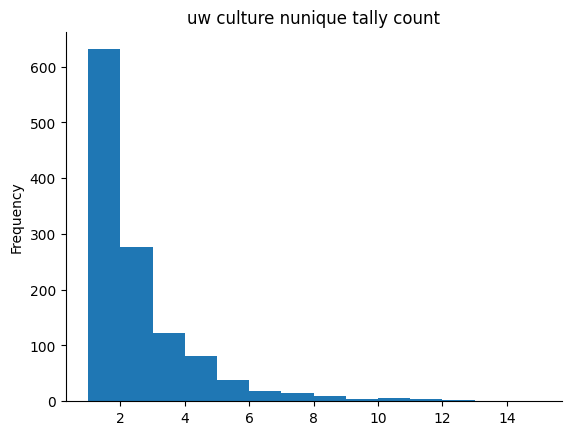

In [ ]:
# UW Medicine
# compute number of uniques tally(DATE+H) for each pacient
uw_culture['tally'] = uw_culture.cxDay*24+uw_culture.cxHour
df = uw_culture.groupby('STUDYID').tally.nunique().to_frame()
display(df.describe()) #
# plot
df['tally'].plot(kind='hist', bins=14, title='uw culture nunique tally count' )
plt.gca().spines[['top', 'right',]].set_visible(False)

,charttime
count,1524.000000
mean,11.013123
std,11.213611
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,177.000000


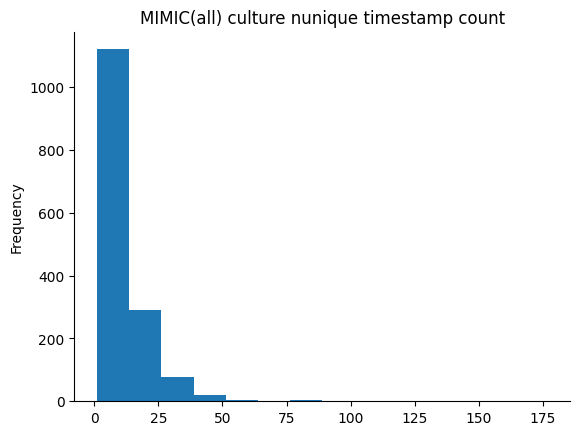

In [ ]:
# MIMIC III
# compute number of uniques tally(DATE+H) for each pacient
culture['tc_date'] =  pd.to_datetime(culture['charttime']).dt.date
culture['tc_hour'] =  pd.to_datetime(culture['charttime']).dt.hour
culture = culture.drop_duplicates(['hadm_id','tc_date','tc_hour'])
df = culture.groupby('hadm_id').charttime.nunique().to_frame()
display(df.describe()) #
# plot
df['charttime'].plot(kind='hist', bins=14, title='MIMIC(all) culture nunique timestamp count' )
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-47-db156dd292a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culture_df['tc_date'] =  pd.to_datetime(culture_df['charttime']).dt.date
<ipython-input-47-db156dd292a7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culture_df['tc_hour'] =  pd.to_datetime(culture_df['charttime']).dt.hour


,charttime
count,1506.000000
mean,9.183267
std,9.315347
min,1.000000
25%,3.000000
50%,7.000000
75%,12.000000
max,169.000000


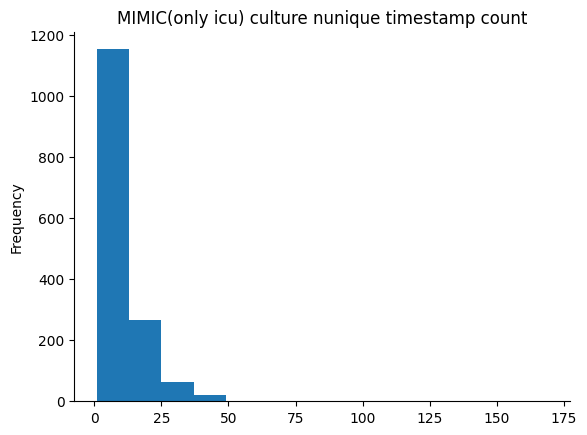

In [ ]:
# MIMIC III
# Drop recordes not in icustay
culture_df = culture_icu.dropna(subset=['icustay_id'])
# compute number of uniques charttime(DATE+CLOCK) for each pacient
culture_df['tc_date'] =  pd.to_datetime(culture_df['charttime']).dt.date
culture_df['tc_hour'] =  pd.to_datetime(culture_df['charttime']).dt.hour
culture_df = culture_df.drop_duplicates(['hadm_id','tc_date','tc_hour'])

df = culture_df.groupby('hadm_id').charttime.nunique().to_frame()
display(df.describe()) #
# plot
df['charttime'].plot(kind='hist', bins=14, title='MIMIC(only icu) culture nunique timestamp count' )
plt.gca().spines[['top', 'right',]].set_visible(False)

For each uniques Culture Source of each pacient(hadm_id), compute num of recordes

### count for each culture source

,charttime
count,67.000000
mean,304.477612
std,961.278416
min,1.000000
25%,2.000000
50%,10.000000
75%,68.500000
max,6130.000000


For each pacients and culture source


,charttime
spec_type_desc,
BLOOD CULTURE,6130
CATHETER TIP-IV,1053
MRSA SCREEN,2209
SPUTUM,3190
STOOL,1036
URINE,3339


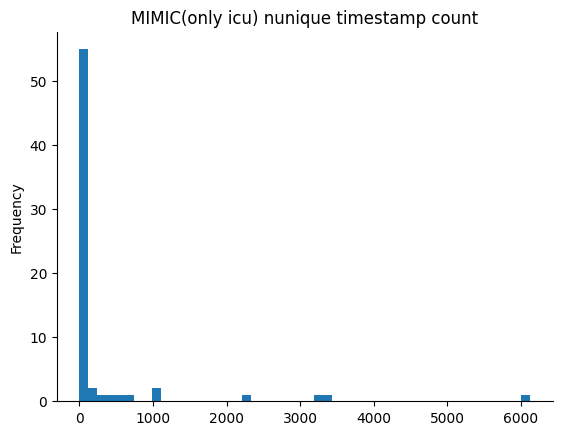

In [ ]:
# For each culture source
df = culture_icu.groupby(['spec_type_desc']).charttime.nunique().to_frame()
display(df.describe()) #
# plot
print('For each pacients and culture source')
df['charttime'].plot(kind='hist', bins=50, title='MIMIC(only icu) nunique timestamp count' )
plt.gca().spines[['top', 'right',]].set_visible(False)
df[df.charttime>1000]

,charttime
count,7852.000000
mean,2.598446
std,2.860420
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,112.000000


For each pacients and culture source


charttime
hadm_id spec_type_desc                       
100619  BLOOD CULTURE                      21
123399  BLOOD CULTURE                      21
130512  BLOOD CULTURE                      26
133294  BLOOD CULTURE                      21
137855  BLOOD CULTURE                      24
138363  BLOOD CULTURE                      31
144799  BLOOD CULTURE                      29
154148  Arterial Line Tip Cultured        112
        BLOOD CULTURE                      31
157559  BLOOD CULTURE                      21
164648  BLOOD CULTURE                      28
165594  BLOOD CULTURE                      22
169535  BLOOD CULTURE                      30

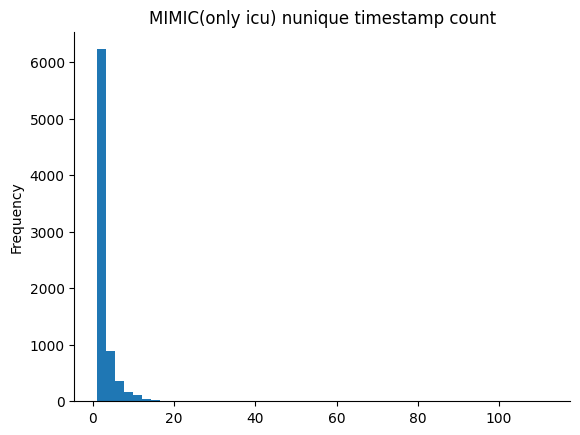

In [ ]:
# For each patient count num of unique timestemp for each culture source
df = culture_icu.groupby(['hadm_id','spec_type_desc']).charttime.nunique().to_frame()
display(df.describe()) #
# plot
print('For each pacients and culture source')
df['charttime'].plot(kind='hist', bins=50, title='MIMIC(only icu) nunique timestamp count' )
plt.gca().spines[['top', 'right',]].set_visible(False)
# show outlier
df[df.charttime>20]

## culture source

In [ ]:
display(uw_culture.SpecimenSource.unique())
# save in a excel file
pd.DataFrame(pd.read_csv('/content/cultures_clean_2016_2019_ICUall_No_Time_Restrictions.csv').SpecimenSource.unique())#.to_excel("cx_Source.xlsx")

array(['Wound', 'Tissue', 'Urine', 'Sputum', 'Bronchoalveolar Lavage',
       'Blood', 'Bronchial Brush', 'Cerebrospinal Fluid',
       'Sputum, Induced', 'Endotracheal Tube Suction', 'Fluid',
       'Catheter Tip', 'Bronchial Wash', 'Pleural Fluid',
       'Bronchoalveolar Lavage, blind', 'Bronchial Washings',
       'Ascites Fluid', 'CSF (Pre-Centrifugation)', 'Abdominal Fluid',
       'Upper Quadrant, Left', 'Peritoneal Fluid', 'Urine, Clean Catch',
       'Lumbar puncture', 'Tracheal Aspirate', 'Triplelumen Catheter Tip',
       'Abscess', 'Suprapubic Specimen', 'Thoracentesis Fluid'],
      dtype=object)

,0
0,Urine
1,Wound
2,Tissue
3,Sputum
4,Bronchoalveolar Lavage
5,Blood
6,Bronchial Brush
7,Cerebrospinal Fluid
8,"Sputum, Induced"
9,Endotracheal Tube Suction


In [ ]:
culture[['spec_itemid','spec_type_desc','linksto']].drop_duplicates()#.to_excel("cx_Source_mimic.xlsx")

,spec_itemid,spec_type_desc,linksto
107,225734.0,Presep Catheter Line Tip Cultured,ChartEvents
108,225722.0,Arterial Line Tip Cultured,ChartEvents
527,226131.0,ICP Line Tip Cultured,ChartEvents
529,225729.0,Multi Lumen Line Tip Cultured,ChartEvents
925,227726.0,AVA Line Tip Cultured,ChartEvents
...,...,...,...
445904,70009.0,BILE,MicrobiologyEvents
555093,70002.0,THROAT FOR STREP,MicrobiologyEvents
509683,70089.0,Blood (Malaria),MicrobiologyEvents
624158,70058.0,RAPID RESPIRATORY VIRAL ANTIGEN TEST,MicrobiologyEvents


In [ ]:
culture_icu[['spec_itemid','spec_type_desc','linksto']].drop_duplicates()#.to_excel("cx_Source_mimic.xlsx")

,spec_itemid,spec_type_desc,linksto
107,225734.0,Presep Catheter Line Tip Cultured,ChartEvents
108,225722.0,Arterial Line Tip Cultured,ChartEvents
527,226131.0,ICP Line Tip Cultured,ChartEvents
529,225729.0,Multi Lumen Line Tip Cultured,ChartEvents
925,227726.0,AVA Line Tip Cultured,ChartEvents
...,...,...,...
188821,70024.0,VIRAL CULTURE: R/O CYTOMEGALOVIRUS,MicrobiologyEvents
239529,70044.0,Influenza A/B by DFA - Bronch Wash,MicrobiologyEvents
445904,70009.0,BILE,MicrobiologyEvents
479787,70029.0,DIALYSIS FLUID,MicrobiologyEvents


In [ ]:
item_all = culture[['spec_itemid','spec_type_desc','linksto']].drop_duplicates()
item_icu = culture_icu[['spec_itemid','spec_type_desc','linksto']].drop_duplicates()
item_all[~(item_all['spec_itemid'].isin(culture_icu.spec_itemid))]

,spec_itemid,spec_type_desc,linksto
65971,70060.0,Stem Cell - Blood Culture,MicrobiologyEvents
65988,70075.0,THROAT CULTURE,MicrobiologyEvents
188693,70019.0,BONE MARROW - CYTOGENETICS,MicrobiologyEvents
219932,70055.0,POSTMORTEM CULTURE,MicrobiologyEvents
555093,70002.0,THROAT FOR STREP,MicrobiologyEvents
624158,70058.0,RAPID RESPIRATORY VIRAL ANTIGEN TEST,MicrobiologyEvents
577974,70037.0,FOOT CULTURE,MicrobiologyEvents


## samples

In [ ]:
sample = culture_icu[culture_icu.hadm_id==154148].sort_values(['charttime','spec_type_desc'])
display(sample.nunique())
sample.to_excel("cx_smaple_154148.xlsx")

subject_id          1
hadm_id             1
icustay_id          1
charttime         196
spec_itemid        16
spec_type_desc     14
linksto             2
dtype: int64

In [ ]:
sample = culture_icu[culture_icu.hadm_id==122154].sort_values(['charttime','spec_type_desc'])
display(sample.nunique())
display(sample.groupby(['spec_type_desc']).charttime.nunique())

# sample.to_excel("cx_smaple_122154.xlsx")

subject_id         1
hadm_id            1
icustay_id         1
charttime         69
spec_itemid       14
spec_type_desc    14
linksto            2
dtype: int64

spec_type_desc
Arterial Line Tip Cultured                  13
BLOOD CULTURE                               19
BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)         1
BRONCHOALVEOLAR LAVAGE                       1
CATHETER TIP-IV                              2
Dialysis Catheter Tip Cultured               3
Immunology (CMV)                             1
Influenza A/B by DFA                         1
MRSA SCREEN                                  4
Multi Lumen Line Tip Cultured               12
Rapid Respiratory Viral Screen & Culture     1
SPUTUM                                      10
STOOL                                        7
URINE                                       13
Name: charttime, dtype: int64

In [ ]:
uw_culture.head()

,STUDYID,day,hour,cxDay,cxHour,source,SpecimenSource,ObservationDetail,tally
1,482,13,9,13,9,Wound.Tissue.Fluid.Abscess,Wound,Occasional ~Acinetobacter baumannii calcoaceti...,321
2,482,13,9,13,9,Wound.Tissue.Fluid.Abscess,Wound,1+ Finegoldia magna (formerly Peptostreptococc...,321
3,482,13,9,13,9,Wound.Tissue.Fluid.Abscess,Wound,2+ Anaerobic gram positive cocci ~: For additi...,321
4,482,13,9,13,9,Wound.Tissue.Fluid.Abscess,Tissue,Occasional ~Anaerobic gram positive cocci ~: F...,321
5,4812,9,20,9,20,Genitourinary,Urine,">100,000 Col/mL ~Escherichia coli",236


In [ ]:
culture.head()

,subject_id,hadm_id,icustay_id,charttime,spec_itemid,spec_type_desc
107,711,158767,270525.0,2185-03-31 20:00:00,225734.0,Presep Catheter Line Tip Cultured
108,711,158767,270525.0,2185-04-09 23:49:00,225722.0,Arterial Line Tip Cultured
527,2830,193970,262270.0,2106-08-09 19:47:00,226131.0,ICP Line Tip Cultured
528,2830,193970,262270.0,2106-08-16 00:24:00,225722.0,Arterial Line Tip Cultured
529,2830,193970,262270.0,2106-08-17 16:00:00,225729.0,Multi Lumen Line Tip Cultured


In [ ]:
culture_icu.head()

,subject_id,hadm_id,icustay_id,charttime,spec_itemid,spec_type_desc
107,711,158767,270525.0,2185-03-31 20:00:00,225734.0,Presep Catheter Line Tip Cultured
108,711,158767,270525.0,2185-04-09 23:49:00,225722.0,Arterial Line Tip Cultured
527,2830,193970,262270.0,2106-08-09 19:47:00,226131.0,ICP Line Tip Cultured
528,2830,193970,262270.0,2106-08-16 00:24:00,225722.0,Arterial Line Tip Cultured
529,2830,193970,262270.0,2106-08-17 16:00:00,225729.0,Multi Lumen Line Tip Cultured


# Antibiotics




In [ ]:
def antibiotics_selection(dataset_path, trum_ids_df,
                          ivs_route_li=['IV'],
                          oral_route_li = ['PO', 'PO/NG', 'PO OR ENTERAL TUBE', 'PO/OG'], # only PO & PO/NG appear in two select oral antibiotics
                          ):
    """
    With respect to all patients
    Select all antibiotics given IV & two oral antibiotics: vancomycin and linezolid
    AND
    Exclude the following prophylactic antibiotics: cefazolin, ampicillin-sulbactam, erythromycin
      (this area can be experimented with, but definitely exclude cefazolin)
    Extra only trauma patients' records
    """
    # # load file
    # prescriptions_name_path = os.path.join(dataset_path, "PRESCRIPTIONS.csv.gz")
    # prescriptions_df = utils.load_df(prescriptions_name_path)
    # prescriptions_df['DRUG_NAME_GENERIC'] = prescriptions_df['DRUG_NAME_GENERIC'].fillna(prescriptions_df['DRUG']) # fill missing drug name
    # prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])

    anti_df = utils.run_query(
    """
    -- Based on MIT-LCP Github project & UW Medicine project
    -- Ref: mimic-iv/concepts/medication/antibiotic.sql
    -- https://github.com/MIT-LCP/mimic-code/blob/b9ed7a3d22a85dd95a50797e15bd24d566bce337/mimic-iv/concepts/medication/antibiotic.sql#L4
    WITH abx AS (
        SELECT DISTINCT
            gsn
            , drug
            , route
            , CASE
                WHEN LOWER(drug) LIKE '%amikacin%' THEN 1
                WHEN LOWER(drug) LIKE '%amphotericin%' THEN 1
                WHEN LOWER(drug) LIKE '%ampicillin%' THEN 1
                WHEN LOWER(drug) LIKE '%azithromycin%' THEN 1
                WHEN LOWER(drug) LIKE '%aztreonam%' THEN 1
                WHEN LOWER(drug) LIKE '%cefazolin%' THEN 1
                WHEN LOWER(drug) LIKE '%ceftazidime%' THEN 1
                WHEN LOWER(drug) LIKE '%cefepime%' THEN 1
                WHEN LOWER(drug) LIKE '%cefotetan%' THEN 1
                WHEN LOWER(drug) LIKE '%cefotaxime%' THEN 1
                WHEN LOWER(drug) LIKE '%ceftriaxone%' THEN 1
                WHEN LOWER(drug) LIKE '%cefuroxime%' THEN 1
                WHEN LOWER(drug) LIKE '%cipro%' THEN 1
                WHEN LOWER(drug) LIKE '%ciprofloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%clindamycin%' THEN 1
                WHEN LOWER(drug) LIKE '%doxycy%' THEN 1
                WHEN LOWER(drug) LIKE '%erythromycin%' THEN 1
                WHEN LOWER(drug) LIKE '%gentamicin%' THEN 1
                WHEN LOWER(drug) LIKE '%levofloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%linezolid%' THEN 1
                WHEN LOWER(drug) LIKE '%metronidazole%' THEN 1
                WHEN LOWER(drug) LIKE '%meropenem%' THEN 1
                WHEN LOWER(drug) LIKE '%metronidazole%' THEN 1
                WHEN LOWER(drug) LIKE '%meropenem%' THEN 1
                WHEN LOWER(drug) LIKE '%minocycline%' THEN 1
                WHEN LOWER(drug) LIKE '%moxifloxacin%' THEN 1
                WHEN LOWER(drug) LIKE '%nafcillin%' THEN 1
                WHEN LOWER(drug) LIKE '%penicillin%' THEN 1
                WHEN LOWER(drug) LIKE '%piperacillin%' THEN 1
                WHEN LOWER(drug) LIKE '%rifampin%' THEN 1
                WHEN LOWER(drug) LIKE '%sulfamethoxazole%' THEN 1
                WHEN LOWER(drug) LIKE '%trimethoprim%' THEN 1
                WHEN LOWER(drug) LIKE '%vancomycin%' THEN 1
                -- Additional abx
                WHEN LOWER(drug) LIKE '%ertapenem%' THEN 1
                WHEN LOWER(drug) LIKE '%imipenem-cilastatin%' THEN 1
                ELSE 0
            END AS antibiotic
        FROM `physionet-data.mimiciii_clinical.prescriptions`
        WHERE route IN (
          'IV', 'IV DRIP', 'IVPCA', 'IV BOLUS', 'EX-VIVO', 'PO/IV', 'IVT', 'IVS' -- iv
          ,'PO/NG','PO', 'NG', 'ORAL' -- oral
        )
    )
    SELECT
        pr.subject_id, pr.hadm_id, pr.icustay_id
        , pr.gsn
        , pr.drug --AS antibiotic
        , pr.drug_name_generic
        , pr.route
        , pr.startdate
        , pr.enddate
    FROM `physionet-data.mimiciii_clinical.prescriptions` pr
    -- inner join to subselect to only antibiotic prescriptions
    INNER JOIN abx
        ON pr.drug = abx.drug
            AND pr.route = abx.route
    WHERE abx.antibiotic = 1
    ;
    """, PROJECT_ID)
    anti_df['startdate'] = pd.to_datetime(anti_df['startdate'])
    # anti_df['DRUG_NAME_GENERIC'] = anti_df['DRUG_NAME_GENERIC'].fillna(anti_df['DRUG']) # fill missing drug name

    # Exclude abx with desensitization label
    anti_df = anti_df[~(anti_df["drug"].apply(lambda x: "desensitization" in str(x).lower()))]


    # selected column list
    cols = ['hadm_id',#'SUBJECT_ID', 'ICUSTAY_ID', # ids
            'startdate', #timepoint
            'gsn', 'drug', 'drug_name_generic', 'route' #drug info
            ]
    """
    TO get qualified iv antibiotics
      We first included all antibiotics given IV
      then exclude the following antibiotics: "cefazolin", "ampicillin-sulbactam","erythromycin"
      (this area can be experimented with, but definitely exclude cefazolin)
    """
    # get all ivs
    # iv_antibiotics_df = anti_df.loc[anti_df['route'].isin(ivs_route_li), cols]#.sort_values(cols)
    iv_antibiotics_df = anti_df.loc[anti_df["route"].apply(lambda x: "iv" in str(x).lower()), cols]
    iv_anti_size = iv_antibiotics_df.shape[0]
    # labeled 3 prophylactic abx (as 1), may want to exclude
    iv_antibiotics_df['isProphylactic'] = np.zeros(iv_antibiotics_df.shape[0])
    iv_antibiotics_df.loc[(
        iv_antibiotics_df["drug"].apply(lambda x: "cefazolin" in str(x).lower())
        | iv_antibiotics_df["drug"].apply(lambda x: "sulbactam" in str(x).lower())
        | iv_antibiotics_df["drug"].apply(lambda x: "erythromycin" in str(x).lower())
        ), "isProphylactic"] = 1
    # this area can be experimented with, but definitely exclude cefazolin
    qualified_iv_antibiotics_df = iv_antibiotics_df[~(iv_antibiotics_df["drug"].apply(lambda x: "cefazolin" in str(x).lower())
                                                      # | iv_antibiotics_df["drug"].apply(lambda x: "sulbactam" in str(x).lower())
                                                      # | iv_antibiotics_df["drug"].apply(lambda x: "erythromycin" in str(x).lower())
                                                      )]
    qualified_iv_anti_size = qualified_iv_antibiotics_df.shape[0]
    print(f"remove {iv_anti_size-qualified_iv_anti_size} unqualified iv antibiotics samples")
    # qualified_iv_antibiotics_df = qualified_iv_antibiotics_df.drop_duplicates()

    """
    TO get qualified oral antibiotics
      We included two oral antibiotics: vancomycin and linezolid
    """
    oral_antibiotics_df = anti_df.loc[anti_df['route'].isin(oral_route_li), cols]#.sort_values(cols)
    # vancomycin
    qualify_oral_antibiotics_df_van = oral_antibiotics_df[oral_antibiotics_df["drug"].apply(lambda x: "vancomycin" in str(x).lower())][cols]
    qualify_oral_antibiotics_df_van = qualify_oral_antibiotics_df_van#.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE'])
    # linezolid
    qualify_oral_antibiotics_df_lin = oral_antibiotics_df[oral_antibiotics_df["drug"].apply(lambda x: "linezolid" in str(x).lower())][cols]
    qualify_oral_antibiotics_df_lin = qualify_oral_antibiotics_df_lin#.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE'])
    # gen two oral antibiotics
    qualify_oral_antibiotics_df = qualify_oral_antibiotics_df_van.append(qualify_oral_antibiotics_df_lin)#.drop_duplicates()
    qualify_oral_antibiotics_df['isProphylactic'] = np.zeros(qualify_oral_antibiotics_df.shape[0])

    # append iv and oral
    qualify_antibiotics_df = qualified_iv_antibiotics_df.append(qualify_oral_antibiotics_df)#.drop_duplicates()
    print("---SUMMARY---")
    print(f"include {qualified_iv_antibiotics_df.shape[0]} qualified iv antibiotics samples")
    print('and')
    print(f"include {qualify_oral_antibiotics_df.shape[0]} qualified oral antibiotics samples")
    print(f"after drop duplicates we have {qualify_antibiotics_df.shape} qualify antibiotics")

    # select trum pacients
    # qualify_antibiotics_df.rename(str.lower, axis=1, inplace=True)
    trum_qualify_antibiotics_df = qualify_antibiotics_df[qualify_antibiotics_df.hadm_id.isin(trum_ids_df.hadm_id)]

    # clean up charttime
    trum_qualify_antibiotics_df = trum_qualify_antibiotics_df.dropna(subset=['hadm_id','startdate'])
    # trum_qualify_antibiotics_df = trum_ids_df.merge(qualify_antibiotics_df, on=['subject_id', 'hadm_id', 'icustay_id'])
    print("TOTAL num of antibiotics TRAUMA samples:", trum_qualify_antibiotics_df.shape)
    return trum_qualify_antibiotics_df.sort_values(['hadm_id', 'startdate']).reset_index(drop=True)

abx = antibiotics_selection(DATASET_PATH, trum_ids_df)
abx
# abx.to_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_antibiotics.csv"))

remove 52831 unqualified iv antibiotics samples


<ipython-input-19-4836d1056a79>:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qualify_oral_antibiotics_df = qualify_oral_antibiotics_df_van.append(qualify_oral_antibiotics_df_lin)#.drop_duplicates()
<ipython-input-19-4836d1056a79>:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qualify_antibiotics_df = qualified_iv_antibiotics_df.append(qualify_oral_antibiotics_df)#.drop_duplicates()


---SUMMARY---
include 635656 qualified iv antibiotics samples
and
include 4904 qualified oral antibiotics samples
after drop duplicates we have (640560, 7) qualify antibiotics
TOTAL num of antibiotics TRAUMA samples: (43559, 7)


,hadm_id,startdate,gsn,drug,drug_name_generic,route,isProphylactic
0,100011,2177-09-05,024095,CefePIME,None,IV,0.0
1,100011,2177-09-05,024095,CefePIME,None,IV,0.0
2,100011,2177-09-05,024095,CefePIME,None,IV,0.0
3,100011,2177-09-05,024095,CefePIME,None,IV,0.0
4,100011,2177-09-05,043952,Vancomycin,None,IV,0.0
...,...,...,...,...,...,...,...
43554,199976,2182-02-14,009331,Vancomycin HCl,None,IV,0.0
43555,199976,2182-02-14,009331,Vancomycin HCl,None,IV,0.0
43556,199976,2182-02-23,009329,Vancomycin HCl,None,IV,0.0
43557,199976,2182-02-23,009329,Vancomycin HCl,None,IV,0.0


In [ ]:
# Saved
abx[['drug', 'drug_name_generic', 'route']].drop_duplicates(['drug', 'route']).sort_values("drug").to_excel("abx.xlsx")
# # Save all the abx name list we select
# abx.to_csv(os.path.join(PREPROCESS_DATA_PATH, "trum_qualify_antibiotics.csv"))

In [ ]:
abx[['drug', 'drug_name_generic', 'route']].drop_duplicates(['drug', 'route']).sort_values("drug")

,drug,drug_name_generic,route
41664,*NF* Nafcillin Sodium,None,IV
29386,Amikacin,None,IV
10529,Amphotericin B,None,IV
614,Ampicillin Sodium,None,IV
147,Ampicillin-Sulbactam,None,IV
1773,Azithromycin,None,IV
216,Aztreonam,None,IV
825,CefTAZidime,None,IV
663,CefTRIAXone,None,IV
0,CefePIME,None,IV


## Reference

### UW Medicine

In [ ]:
uw_abx = pd.read_excel('/content/Sepsis16to19_Antibiotics_092921.xlsx',sheet_name='AbxRoute')
uw_abx_name_df = uw_abx[['EVENT_CD_DESCR', 'OE_FIELD_DISPLAY_VALUE']].drop_duplicates()
uw_abx_name_df = pd.concat([
    uw_abx_name_df[uw_abx_name_df['OE_FIELD_DISPLAY_VALUE'].isin(['IV', 'IV Infusion', 'IVPB'])],
    uw_abx_name_df[(uw_abx_name_df['EVENT_CD_DESCR'].isin(['vancomycin', 'linezolid'])) & (uw_abx.OE_FIELD_DISPLAY_VALUE=='PO')]
    ],axis=0).sort_values('EVENT_CD_DESCR')#.to_excel("abx_name_uw.xlsx")
print(uw_abx_name_df.shape)
uw_abx_name_df.head()

(44, 2)


<ipython-input-45-6dbbc6d61708>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uw_abx_name_df[(uw_abx_name_df['EVENT_CD_DESCR'].isin(['vancomycin', 'linezolid'])) & (uw_abx.OE_FIELD_DISPLAY_VALUE=='PO')]


,EVENT_CD_DESCR,OE_FIELD_DISPLAY_VALUE
16742,DAPTOmycin,IVPB
4293,ampicillin,IVPB
23,ampicillin-sulbactam,IVPB
93,azithromycin,IVPB
9768,aztreonam,IVPB


### Microsoft

In [ ]:
prescriptions_name_path = os.path.join(DATASET_PATH, "PRESCRIPTIONS.csv.gz")
prescriptions_df = utils.load_df(prescriptions_name_path)

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimic_utils.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col="ROW_ID")


In [ ]:
prescriptions_name_path = os.path.join(DATASET_PATH, "PRESCRIPTIONS.csv.gz")
prescriptions_df = utils.load_df(prescriptions_name_path)
prescriptions_df['DRUG_NAME_GENERIC'] = prescriptions_df['DRUG_NAME_GENERIC'].fillna(prescriptions_df['DRUG']) # fill missing drug name

microsoft_abx_df = prescriptions_df[prescriptions_df.GSN.isin(['002542','002543','007371','008873','008877','008879','008880','008935','008941',
                                                    '008942','008943','008944','008983','008984','008990','008991','008992','008995','008996',
                                                    '008998','009043','009046','009065','009066','009136','009137','009162','009164','009165',
                                                    '009171','009182','009189','009213','009214','009218','009219','009221','009226','009227',
                                                    '009235','009242','009263','009273','009284','009298','009299','009310','009322','009323',
                                                    '009326','009327','009339','009346','009351','009354','009362','009394','009395','009396',
                                                    '009509','009510','009511','009544','009585','009591','009592','009630','013023','013645',
                                                    '013723','013724','013725','014182','014500','015979','016368','016373','016408','016931',
                                                    '016932','016949','018636','018637','018766','019283','021187','021205','021735','021871',
                                                    '023372','023989','024095','024194','024668','025080','026721','027252','027465','027470',
                                                    '029325','029927','029928','037042','039551','039806','040819','041798','043350','043879',
                                                    '044143','045131','045132','046771','047797','048077','048262','048266','048292','049835',
                                                    '050442','050443','051932','052050','060365','066295','067471'])]
# get all ivs
# iv_antibiotics_df = anti_df.loc[anti_df['ROUTE'].isin(ivs_route_li), cols]#.sort_values(cols)
microsoft_iv_abx_name_df = microsoft_abx_df.loc[microsoft_abx_df["ROUTE"].apply(lambda x: "iv" in str(x).lower()),
                                     ['GSN', 'DRUG_NAME_GENERIC', 'ROUTE']].drop_duplicates()
print(microsoft_iv_abx_name_df.shape)
microsoft_iv_abx_name_df.head()

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimic_utils.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col="ROW_ID")


(57, 3)


,GSN,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,
2378253,009298,NEO*IV*Gentamicin,IV
616851,021187,Piperacillin-Tazobactam Na,IV
1968651,009066,Cefazolin,IV
1641156,009221,Doxycycline Hyclate,IV
2907881,009066,CefazoLIN,IV


### MIT-LCP

In [ ]:
prescriptions_df.loc[prescriptions_df["ROUTE"].apply(lambda x: "iv" in str(x).lower()),
                                     'ROUTE'].unique()

array(['IV', 'IV DRIP', 'IVPCA', 'IV BOLUS', 'EX-VIVO', 'PO/IV', 'IVT',
       'IVS'], dtype=object)

In [ ]:
utils.run_query(
"""
WITH abx AS (
  SELECT DISTINCT
    gsn
    , drug
    , route
    , CASE
        WHEN LOWER(drug) LIKE '%linezolid%' THEN 1 -- oral
        WHEN LOWER(drug) LIKE '%vancomycin%' THEN 1 -- Oral
        ELSE 0
    END AS antibiotic
FROM `physionet-data.mimiciii_clinical.prescriptions`
)
SELECT *
FROM abx
WHERE antibiotic=1
""", PROJECT_ID).route.unique()

array(['PO/NG', 'IT', 'IV', 'PO', 'IVT', 'LOCK', 'PB', 'PR', 'NG', 'ORAL',
       'RIGHT EYE', 'LEFT EYE', 'OU', 'OD', 'IP', 'IJ', 'IRR', 'G TUBE',
       'IH', 'J TUBE', 'NAS'], dtype=object)

In [ ]:
mit_abx_df = utils.run_query(
"""
-- Ref: mimic-iv/concepts/medication/antibiotic.sql
-- https://github.com/MIT-LCP/mimic-code/blob/b9ed7a3d22a85dd95a50797e15bd24d566bce337/mimic-iv/concepts/medication/antibiotic.sql#L4
WITH abx AS (
    SELECT DISTINCT
        gsn
        , drug
        , route
        , CASE
            WHEN LOWER(drug) LIKE '%adoxa%' THEN 1
            WHEN LOWER(drug) LIKE '%ala-tet%' THEN 1
            WHEN LOWER(drug) LIKE '%alodox%' THEN 1
            WHEN LOWER(drug) LIKE '%amikacin%' THEN 1
            WHEN LOWER(drug) LIKE '%amikin%' THEN 1
            WHEN LOWER(drug) LIKE '%amoxicill%' THEN 1
            WHEN LOWER(drug) LIKE '%amphotericin%' THEN 1
            WHEN LOWER(drug) LIKE '%anidulafungin%' THEN 1
            WHEN LOWER(drug) LIKE '%ancef%' THEN 1
            WHEN LOWER(drug) LIKE '%clavulanate%' THEN 1
            WHEN LOWER(drug) LIKE '%ampicillin%' THEN 1
            WHEN LOWER(drug) LIKE '%augmentin%' THEN 1
            WHEN LOWER(drug) LIKE '%avelox%' THEN 1
            WHEN LOWER(drug) LIKE '%avidoxy%' THEN 1
            WHEN LOWER(drug) LIKE '%azactam%' THEN 1
            WHEN LOWER(drug) LIKE '%azithromycin%' THEN 1
            WHEN LOWER(drug) LIKE '%aztreonam%' THEN 1
            WHEN LOWER(drug) LIKE '%axetil%' THEN 1
            WHEN LOWER(drug) LIKE '%bactocill%' THEN 1
            WHEN LOWER(drug) LIKE '%bactrim%' THEN 1
            WHEN LOWER(drug) LIKE '%bactroban%' THEN 1
            WHEN LOWER(drug) LIKE '%bethkis%' THEN 1
            WHEN LOWER(drug) LIKE '%biaxin%' THEN 1
            WHEN LOWER(drug) LIKE '%bicillin l-a%' THEN 1
            WHEN LOWER(drug) LIKE '%cayston%' THEN 1
            WHEN LOWER(drug) LIKE '%cefazolin%' THEN 1
            WHEN LOWER(drug) LIKE '%cedax%' THEN 1
            WHEN LOWER(drug) LIKE '%cefoxitin%' THEN 1
            WHEN LOWER(drug) LIKE '%ceftazidime%' THEN 1
            WHEN LOWER(drug) LIKE '%cefaclor%' THEN 1
            WHEN LOWER(drug) LIKE '%cefadroxil%' THEN 1
            WHEN LOWER(drug) LIKE '%cefdinir%' THEN 1
            WHEN LOWER(drug) LIKE '%cefditoren%' THEN 1
            WHEN LOWER(drug) LIKE '%cefepime%' THEN 1
            WHEN LOWER(drug) LIKE '%cefotan%' THEN 1
            WHEN LOWER(drug) LIKE '%cefotetan%' THEN 1
            WHEN LOWER(drug) LIKE '%cefotaxime%' THEN 1
            WHEN LOWER(drug) LIKE '%ceftaroline%' THEN 1
            WHEN LOWER(drug) LIKE '%cefpodoxime%' THEN 1
            WHEN LOWER(drug) LIKE '%cefpirome%' THEN 1
            WHEN LOWER(drug) LIKE '%cefprozil%' THEN 1
            WHEN LOWER(drug) LIKE '%ceftibuten%' THEN 1
            WHEN LOWER(drug) LIKE '%ceftin%' THEN 1
            WHEN LOWER(drug) LIKE '%ceftriaxone%' THEN 1
            WHEN LOWER(drug) LIKE '%cefuroxime%' THEN 1
            WHEN LOWER(drug) LIKE '%cephalexin%' THEN 1
            WHEN LOWER(drug) LIKE '%cephalothin%' THEN 1
            WHEN LOWER(drug) LIKE '%cephapririn%' THEN 1
            WHEN LOWER(drug) LIKE '%chloramphenicol%' THEN 1
            WHEN LOWER(drug) LIKE '%cipro%' THEN 1
            WHEN LOWER(drug) LIKE '%ciprofloxacin%' THEN 1
            WHEN LOWER(drug) LIKE '%claforan%' THEN 1
            WHEN LOWER(drug) LIKE '%clarithromycin%' THEN 1
            WHEN LOWER(drug) LIKE '%cleocin%' THEN 1
            WHEN LOWER(drug) LIKE '%clindamycin%' THEN 1
            WHEN LOWER(drug) LIKE '%cubicin%' THEN 1
            WHEN LOWER(drug) LIKE '%dicloxacillin%' THEN 1
            WHEN LOWER(drug) LIKE '%dirithromycin%' THEN 1
            WHEN LOWER(drug) LIKE '%doryx%' THEN 1
            WHEN LOWER(drug) LIKE '%doxycy%' THEN 1
            WHEN LOWER(drug) LIKE '%duricef%' THEN 1
            WHEN LOWER(drug) LIKE '%dynacin%' THEN 1
            WHEN LOWER(drug) LIKE '%ery-tab%' THEN 1
            WHEN LOWER(drug) LIKE '%eryped%' THEN 1
            WHEN LOWER(drug) LIKE '%eryc%' THEN 1
            WHEN LOWER(drug) LIKE '%erythrocin%' THEN 1
            WHEN LOWER(drug) LIKE '%erythromycin%' THEN 1
            WHEN LOWER(drug) LIKE '%factive%' THEN 1
            WHEN LOWER(drug) LIKE '%flagyl%' THEN 1
            WHEN LOWER(drug) LIKE '%fortaz%' THEN 1
            WHEN LOWER(drug) LIKE '%furadantin%' THEN 1
            WHEN LOWER(drug) LIKE '%garamycin%' THEN 1
            WHEN LOWER(drug) LIKE '%gentamicin%' THEN 1
            WHEN LOWER(drug) LIKE '%kanamycin%' THEN 1
            WHEN LOWER(drug) LIKE '%keflex%' THEN 1
            WHEN LOWER(drug) LIKE '%kefzol%' THEN 1
            WHEN LOWER(drug) LIKE '%ketek%' THEN 1
            WHEN LOWER(drug) LIKE '%levaquin%' THEN 1
            WHEN LOWER(drug) LIKE '%levofloxacin%' THEN 1
            WHEN LOWER(drug) LIKE '%lincocin%' THEN 1
            WHEN LOWER(drug) LIKE '%linezolid%' THEN 1
            WHEN LOWER(drug) LIKE '%macrobid%' THEN 1
            WHEN LOWER(drug) LIKE '%macrodantin%' THEN 1
            WHEN LOWER(drug) LIKE '%maxipime%' THEN 1
            WHEN LOWER(drug) LIKE '%mefoxin%' THEN 1
            WHEN LOWER(drug) LIKE '%metronidazole%' THEN 1
            WHEN LOWER(drug) LIKE '%meropenem%' THEN 1
            WHEN LOWER(drug) LIKE '%methicillin%' THEN 1
            WHEN LOWER(drug) LIKE '%minocin%' THEN 1
            WHEN LOWER(drug) LIKE '%minocycline%' THEN 1
            WHEN LOWER(drug) LIKE '%monodox%' THEN 1
            WHEN LOWER(drug) LIKE '%monurol%' THEN 1
            WHEN LOWER(drug) LIKE '%morgidox%' THEN 1
            WHEN LOWER(drug) LIKE '%moxatag%' THEN 1
            WHEN LOWER(drug) LIKE '%moxifloxacin%' THEN 1
            WHEN LOWER(drug) LIKE '%mupirocin%' THEN 1
            WHEN LOWER(drug) LIKE '%myrac%' THEN 1
            WHEN LOWER(drug) LIKE '%nafcillin%' THEN 1
            WHEN LOWER(drug) LIKE '%neomycin%' THEN 1
            WHEN LOWER(drug) LIKE '%nicazel doxy 30%' THEN 1
            WHEN LOWER(drug) LIKE '%nitrofurantoin%' THEN 1
            WHEN LOWER(drug) LIKE '%norfloxacin%' THEN 1
            WHEN LOWER(drug) LIKE '%noroxin%' THEN 1
            WHEN LOWER(drug) LIKE '%ocudox%' THEN 1
            WHEN LOWER(drug) LIKE '%ofloxacin%' THEN 1
            WHEN LOWER(drug) LIKE '%omnicef%' THEN 1
            WHEN LOWER(drug) LIKE '%oracea%' THEN 1
            WHEN LOWER(drug) LIKE '%oraxyl%' THEN 1
            WHEN LOWER(drug) LIKE '%oxacillin%' THEN 1
            WHEN LOWER(drug) LIKE '%pc pen vk%' THEN 1
            WHEN LOWER(drug) LIKE '%pce dispertab%' THEN 1
            WHEN LOWER(drug) LIKE '%panixine%' THEN 1
            WHEN LOWER(drug) LIKE '%pediazole%' THEN 1
            WHEN LOWER(drug) LIKE '%penicillin%' THEN 1
            WHEN LOWER(drug) LIKE '%periostat%' THEN 1
            WHEN LOWER(drug) LIKE '%pfizerpen%' THEN 1
            WHEN LOWER(drug) LIKE '%piperacillin%' THEN 1
            WHEN LOWER(drug) LIKE '%tazobactam%' THEN 1
            WHEN LOWER(drug) LIKE '%primsol%' THEN 1
            WHEN LOWER(drug) LIKE '%proquin%' THEN 1
            WHEN LOWER(drug) LIKE '%raniclor%' THEN 1
            WHEN LOWER(drug) LIKE '%rifadin%' THEN 1
            WHEN LOWER(drug) LIKE '%rifampin%' THEN 1
            WHEN LOWER(drug) LIKE '%rocephin%' THEN 1
            WHEN LOWER(drug) LIKE '%smz-tmp%' THEN 1
            WHEN LOWER(drug) LIKE '%septra%' THEN 1
            WHEN LOWER(drug) LIKE '%septra ds%' THEN 1
            WHEN LOWER(drug) LIKE '%septra%' THEN 1
            WHEN LOWER(drug) LIKE '%solodyn%' THEN 1
            WHEN LOWER(drug) LIKE '%spectracef%' THEN 1
            WHEN LOWER(drug) LIKE '%streptomycin%' THEN 1
            WHEN LOWER(drug) LIKE '%sulfadiazine%' THEN 1
            WHEN LOWER(drug) LIKE '%sulfamethoxazole%' THEN 1
            WHEN LOWER(drug) LIKE '%trimethoprim%' THEN 1
            WHEN LOWER(drug) LIKE '%sulfatrim%' THEN 1
            WHEN LOWER(drug) LIKE '%sulfisoxazole%' THEN 1
            WHEN LOWER(drug) LIKE '%suprax%' THEN 1
            WHEN LOWER(drug) LIKE '%synercid%' THEN 1
            WHEN LOWER(drug) LIKE '%tazicef%' THEN 1
            WHEN LOWER(drug) LIKE '%tetracycline%' THEN 1
            WHEN LOWER(drug) LIKE '%timentin%' THEN 1
            WHEN LOWER(drug) LIKE '%tobramycin%' THEN 1
            WHEN LOWER(drug) LIKE '%trimethoprim%' THEN 1
            WHEN LOWER(drug) LIKE '%unasyn%' THEN 1
            WHEN LOWER(drug) LIKE '%vancocin%' THEN 1
            WHEN LOWER(drug) LIKE '%vancomycin%' THEN 1
            WHEN LOWER(drug) LIKE '%vantin%' THEN 1
            WHEN LOWER(drug) LIKE '%vibativ%' THEN 1
            WHEN LOWER(drug) LIKE '%vibra-tabs%' THEN 1
            WHEN LOWER(drug) LIKE '%vibramycin%' THEN 1
            WHEN LOWER(drug) LIKE '%zinacef%' THEN 1
            WHEN LOWER(drug) LIKE '%zithromax%' THEN 1
            WHEN LOWER(drug) LIKE '%zosyn%' THEN 1
            WHEN LOWER(drug) LIKE '%zyvox%' THEN 1
            --
            WHEN LOWER(drug) LIKE '%ertapenem%' THEN 1
            WHEN LOWER(drug) LIKE '%imipenem-cilastatin%' THEN 1

            ELSE 0
        END AS antibiotic
    FROM `physionet-data.mimiciii_clinical.prescriptions`
    WHERE route IN (
      'IV', 'IV DRIP', 'IVPCA', 'IV BOLUS', 'EX-VIVO', 'PO/IV', 'IVT', 'IVS' -- iv
      ,'PO/NG','PO', 'NG', 'ORAL' -- oral
    )
)
SELECT
    pr.subject_id, pr.hadm_id, pr.icustay_id
    , pr.gsn
    , pr.drug AS antibiotic
    , pr.drug_name_generic
    , pr.route
    , pr.startdate
    , pr.enddate
FROM `physionet-data.mimiciii_clinical.prescriptions` pr
-- inner join to subselect to only antibiotic prescriptions
INNER JOIN abx
    ON pr.drug = abx.drug
    AND pr.route = abx.route
WHERE abx.antibiotic = 1
;
"""
, PROJECT_ID).drop_duplicates()
print(mit_abx_df.shape)
# mit_abx_df.to_csv(os.path.join(PREPROCESS_DATA_PATH,"antibiotics.csv")) #includes all antibiotics from mimic daatset.

NameError: name 'utils' is not defined

In [ ]:
# load all antibiotics records
mit_abx_df = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH,"antibiotics.csv"),index_col=0)
mit_abx_df['drug_name_generic'] = mit_abx_df['drug_name_generic'].fillna(mit_abx_df['drug']) # fill missing drug name
# select qualify antibiotics
iv_abx_df = mit_abx_df[mit_abx_df["route"].apply(lambda x: "iv" in str(x).lower())] # iv
oral_abx_df = mit_abx_df[mit_abx_df["route"].isin(['PO/NG','PO', 'NG', 'ORAL'])] # oral
qulify_oral_abx_df = oral_abx_df.loc[(oral_abx_df.drug_name_generic.apply(lambda x: "vancomycin" in str(x).lower())) |
                                     (oral_abx_df.drug_name_generic.apply(lambda x: "linezolid" in str(x).lower()))] #qulify oral
qulifyt_abx_df = pd.concat([iv_abx_df, qulify_oral_abx_df], axis=0)

<ipython-input-36-099657e20b7c>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mit_abx_df = pd.read_csv(os.path.join(PREPROCESS_DATA_PATH,"antibiotics.csv"),index_col=0)


In [ ]:
# mit_abx_namr_df = qulifyt_abx_df[['gsn', 'drug_name_generic', 'route']].drop_duplicates().sort_values(['drug_name_generic'])
# mit_abx_namr_df.to_excel("abx_name.xlsx")

In [ ]:
mit_abx_df['drug_name_generic'] = mit_abx_df['drug_name_generic'].fillna(mit_abx_df['drug']) # fill missing drug name
mit_abx_df= pd.concat([
    mit_abx_df[mit_abx_df["route"].apply(lambda x: "iv" in str(x).lower())],
    mit_abx_df[(mit_abx_df.loc[mit_abx_df["drug_name_generic"].apply(lambda x: "vancomycin" in str(x).lower())]) & (mit_abx_df.route.isin(['PO/NG','PO', 'NG', 'ORAL']))],
    mit_abx_df[(mit_abx_df.loc[mit_abx_df["drug_name_generic"].apply(lambda x: "linezolid" in str(x).lower())]) & (mit_abx_df.route.isin(['PO/NG','PO', 'NG', 'ORAL']))]
    ],axis=0)
mit_abx_df[['gsn', 'drug_name_generic', 'route']].sort_values('drug_name_generic')

In [ ]:
mit_abx_df= pd.concat([
    mit_abx_df[mit_abx_df["route"].apply(lambda x: "iv" in str(x).lower())],
    mit_abx_df[(mit_abx_df.loc[mit_abx_df["drug_name_generic"].apply(lambda x: "vancomycin" in str(x).lower())]) & (mit_abx_df.route.isin('PO/NG','PO', 'NG', 'ORAL'))],
    mit_abx_df[(mit_abx_df.loc[mit_abx_df["drug_name_generic"].apply(lambda x: "linezolid" in str(x).lower())]) & (mit_abx_df.route.isin('PO/NG','PO', 'NG', 'ORAL'))]
    ],axis=0).sort_values('EVENT_CD_DESCR')

# mit_abx_name_df = mit_abx[mit_abx.antibiotic==1]
# mit_abx_name_df = pd.concat([
#     mit_abx_name_df[mit_abx_name_df["route"].apply(lambda x: "iv" in str(x).lower())],
#     mit_abx_name_df[(mit_abx_name_df['EVENT_CD_DESCR'].isin(['vancomycin', 'linezolid'])) & (mit_abx_name_df.OE_FIELD_DISPLAY_VALUE=='PO')]
#     ],axis=0).sort_values('EVENT_CD_DESCR')
print(mit_abx_name_df.shape)
mit_abx_name_df.head()

In [ ]:
# mit_abx[mit_abx.drug == ['vancomycin'])]

# mit_abx.loc[mit_abx["drug"].apply(lambda x: "vancomycin" in str(x).lower())]

,gsn,drug,route,antibiotic
28,009331,NEO*IV*Vancomycin,IV,1
29,009329,Vancomycin,PO/NG,1
30,009329,Vancomycin Oral Liquid,PO/NG,1
31,009329,Vancomycin Oral Liquid,PO,1
32,009331,Vancomycin Intraventricular,IVT,1
45,009330,Vancomycin,IV,1
49,009329,Vancomycin,IV,1
50,009329,Vancomycin HCl,IV,1
64,009331,Vancomycin Desensitization,IV,1
116,043952,Vancomycin,IV,1


In [ ]:
display(mit_abx_name_df[mit_abx_name_df["route"].apply(lambda x: "iv" in str(x).lower())].head())
display(
    mit_abx_name_df[
        (mit_abx_name_df.drug.isin(['vancomycin', 'linezolid']))
        # & (mit_abx_name_df.route.isin(['PO', 'PO/NG']))]#.head()
    )


,gsn,drug,route,antibiotic
11,009066,CefazoLIN,IV,1
15,008854,Penicillin G Potassium,IV,1
16,008935,Ampicillin Sodium,IV,1
17,008888,Piperacillin,IV,1
18,008888,Piperacillin Sodium,IV,1


,gsn,drug,route,antibiotic


## abx selection

In [ ]:
prescriptions_name_path = os.path.join(DATASET_PATH, "PRESCRIPTIONS.csv.gz")
prescriptions_df = utils.load_df(prescriptions_name_path)

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimic_utils.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col="ROW_ID")


ValueError: invalid literal for int() with base 10: '024665 041568 044488 043811 026076 '

In [ ]:
prescriptions_df.GSN

In [ ]:
prescriptions_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE'],
      dtype='object')

In [ ]:
gsn = prescriptions_df.loc[(prescriptions_df.DRUG.apply(lambda x: 'moxifloxacin' in str(x).lower())),'GSN'].unique()
print(gsn)
# gsn = ['043879', '049742', '052050', '52050.0']
# prescriptions_df.loc[prescriptions_df.GSN.isin(gsn), ['GSN', 'DRUG', 'DRUG_NAME_GENERIC', 'ROUTE']].drop_duplicates()

# prescriptions_df.loc[(prescriptions_df.DRUG.apply(lambda x: 'moxifloxacin' in str(x).lower())),
#                     ['GSN', 'DRUG', 'DRUG_NAME_GENERIC', 'ROUTE']].drop_duplicates()

In [ ]:
prescriptions_df[prescriptions_df.GSN.isin([
    '009119',  # Cefotaxime
    '021701' '021702' '009181', # Cefotetan

])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
ROW_ID,,,,,,,,,,,,,,,,,,
2577987,72,156857,239612.0,2163-09-23 00:00:00,2163-09-28 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,134,mg,0.67,ml,IV
1904496,92,142807,291001.0,2122-12-15 00:00:00,2122-12-23 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2gm Vial,35,mg,0.18,ml,IV
2257231,478,137370,223124.0,2194-07-19 00:00:00,2194-07-21 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,60,mg,0.3,ml,IV
2896083,513,103472,249657.0,2186-12-25 00:00:00,2186-12-25 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,50,mg,0.25,ml,IV
2774325,517,155972,271348.0,2159-01-03 00:00:00,2159-01-04 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,125,mg,0.625,ml,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164937,31014,143426,234719.0,2113-01-10 00:00:00,2113-01-19 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,124,mg,0.62,mL,IV
3030570,31597,131426,293271.0,2199-05-28 00:00:00,2199-06-03 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,50,mg,0.25,ml,IV
3149496,31824,134738,223506.0,2128-02-13 00:00:00,2128-02-18 00:00:00,MAIN,NEO*IV*Cefotaxime,NaN,NaN,NCEFXIV,009119,39001910.0,2g Vial,60,mg,0.3,mL,IV


In [ ]:
prescriptions_df.gsn.isin([])


In [ ]:
prescriptions_name_path = os.path.join(DATASET_PATH, "PRESCRIPTIONS.csv.gz")
prescriptions_df = utils.load_df(prescriptions_name_path)

# admission_name_path = os.path.join(DATASET_PATH, "ADMISSIONS.csv.gz")
# admission_df = utils.load_df(admission_name_path)

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimic_utils.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col="ROW_ID")


In [ ]:
# prescriptions_df.loc[prescriptions_df.DRUG.apply(lambda x: 'neo' in str(x).lower())]
df = prescriptions_df.loc[prescriptions_df.DRUG.apply(lambda x: 'neo*iv*cefotaxime' in str(x).lower())]
df = df.merge(admission_df, on=['SUBJECT_ID',	'HADM_ID'])

In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [ ]:
df[['HADM_ID', 'ADMITTIME','STARTDATE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC']]

,HADM_ID,ADMITTIME,STARTDATE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC
0,156857,2163-09-22 23:52:00,2163-09-23 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
1,142807,2122-12-13 19:30:00,2122-12-15 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
2,137370,2194-07-15 13:46:00,2194-07-19 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
3,103472,2186-12-15 20:40:00,2186-12-25 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
4,155972,2158-09-09 15:48:00,2159-01-03 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
...,...,...,...,...,...,...
144,143426,2113-01-09 13:09:00,2113-01-10 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
145,131426,2199-05-27 13:57:00,2199-05-28 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
146,134738,2128-02-12 22:59:00,2128-02-13 00:00:00,NEO*IV*Cefotaxime,NaN,NaN
147,100616,2199-12-04 20:56:00,2199-12-04 00:00:00,NEO*IV*Cefotaxime,NaN,NaN


In [ ]:
df = pd.DataFrame()
abx_li = ['cefotaxime', 'cefotetan', 'moxifloxacin', 'nafcillin',
          'ampicillin', 'ceftazidime', 'ceftriaxone', 'clindamycin', 'gentamicin', 'penicillin', 'piperacillin']

for abx_name in abx_li:
  abx_df = prescriptions_df.loc[prescriptions_df.DRUG.apply(lambda x: abx_name in str(x).lower()),
                                # ['DRUG', 'DRUG_NAME_GENERIC', 'NDC', 'ROUTE']
                                ]
  abx_df = abx_df[abx_df.ROUTE.apply(lambda x: "iv" in str(x).lower())]#.drop_duplicates().sort_values(['NDC'])
  abx_df = abx_df[~abx_df.DRUG.apply(lambda x: "desensitization" in str(x).lower())]#.drop_duplicates().sort_values(['NDC'])
  # df = df.append(abx_df)
  df = abx_df.groupby('HADM_ID').DRUG.nunique()
  print(abx_name)
  display(df[df>1])
  # break
# df.to_excel("NEO_NF.xlsx")

cefotaxime


Series([], Name: DRUG, dtype: int64)

cefotetan


Series([], Name: DRUG, dtype: int64)

moxifloxacin


Series([], Name: DRUG, dtype: int64)

nafcillin


HADM_ID
149679    2
Name: DRUG, dtype: int64

ampicillin


HADM_ID
101873    2
103905    2
106614    2
108540    2
109783    2
         ..
194352    2
195557    2
196695    2
197385    2
197487    2
Name: DRUG, Length: 63, dtype: int64

ceftazidime


HADM_ID
132807    2
Name: DRUG, dtype: int64

ceftriaxone


HADM_ID
134480    2
158544    2
159335    2
175668    2
177247    2
185590    2
Name: DRUG, dtype: int64

clindamycin


HADM_ID
159488    2
171336    2
191721    2
192685    2
Name: DRUG, dtype: int64

gentamicin


HADM_ID
100135    2
100242    2
100561    2
100937    2
101098    2
         ..
199301    2
199385    2
199407    2
199788    2
199872    2
Name: DRUG, Length: 305, dtype: int64

penicillin


Series([], Name: DRUG, dtype: int64)

piperacillin


HADM_ID
100456    2
100571    2
100575    2
100659    2
100746    2
         ..
198480    2
199740    2
199757    2
199790    2
199940    2
Name: DRUG, Length: 270, dtype: int64

In [ ]:
prescriptions_df.loc[(prescriptions_df.DRUG.apply(lambda x: 'cefotaxime' in str(x).lower())) #& (prescriptions_df.HADM_ID==196257)
                                ].sort_values(['HADM_ID', 'ICUSTAY_ID', 'STARTDATE']).to_excel("cefotaxime_sample.xlsx")

In [ ]:
prescriptions_df.loc[(prescriptions_df.DRUG.apply(lambda x: 'gentamicin' in str(x).lower())) & (prescriptions_df.HADM_ID==100135)
                                ].sort_values(['HADM_ID', 'ICUSTAY_ID', 'STARTDATE']).to_excel("Gentamicin_sample.xlsx")

In [ ]:
# Smaple of one hadm with different form of DRUG name
prescriptions_df.loc[(prescriptions_df.DRUG.apply(lambda x: 'ceftazidime' in str(x).lower())) & (prescriptions_df.HADM_ID==132807)
                                ].sort_values(['HADM_ID', 'ICUSTAY_ID', 'STARTDATE'])

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
ROW_ID,,,,,,,,,,,,,,,,,,
2817026,307,132807,265862.0,2162-12-01 00:00:00,2162-12-06 00:00:00,MAIN,CeftAZIDime,NaN,NaN,CEFT1F,015538,173041200.0,1g Frozen Bag,1,gm,1,BAG,IV
2817029,307,132807,NaN,2162-12-06 00:00:00,2162-12-07 00:00:00,MAIN,CeftazIDIME,NaN,NaN,CEFT1F,015538,173041200.0,1g Frozen Bag,1,gm,1,BAG,IV
2817030,307,132807,NaN,2162-12-06 00:00:00,2162-12-08 00:00:00,MAIN,CeftazIDIME,NaN,NaN,CEFT1F,015538,173041200.0,1g Frozen Bag,1,gm,1,BAG,IV
2817031,307,132807,NaN,2162-12-08 00:00:00,2162-12-10 00:00:00,MAIN,CeftazIDIME,NaN,NaN,CEFT1F,015538,173041200.0,1g Frozen Bag,1,gm,1,BAG,IV
2817032,307,132807,NaN,2162-12-11 00:00:00,2162-12-14 00:00:00,MAIN,CeftazIDIME,NaN,NaN,CEF2I,009172,173037934.0,2000 mg Vial,500,mg,500,mg,IV


# HERE

In [ ]:
uw_abx_name_df = uw_abx_df[['EVENT_CD_DESCR','OE_FIELD_DISPLAY_VALUE']].drop_duplicates()#.to_excel("abx_name.xlsx")

In [ ]:
# df = pd.DataFrame(columns=['GSN', 'DRUG_NAME_GENERIC','ROUTE'])
# for abx_name in uw_abx_name_df.EVENT_CD_DESCR:
#   df = pd.concat([df, df.loc[df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()
#   ], ignore_index=True)
# pd.concat([s1, s2], ignore_index=True)
# df

# Missing Abx

In [ ]:
prescriptions_name_path = os.path.join(DATASET_PATH, "PRESCRIPTIONS.csv.gz")
prescriptions_df = utils.load_df(prescriptions_name_path)
prescriptions_df['DRUG_NAME_GENERIC'] = prescriptions_df['DRUG_NAME_GENERIC'].fillna(prescriptions_df['DRUG']) # fill missing drug name


/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project/mimic_utils.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col="ROW_ID")


In [ ]:
abx_name = 'daptomycin'
prescriptions_df.loc[prescriptions_df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG','DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()

,GSN,DRUG,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,,
1922552,053190,Daptomycin,Daptomycin,IV
2018661,53190.0,Daptomycin,Daptomycin,IV
586216,053190,Daptomycin,Daptomycin,IP


In [ ]:
abx_name = 'ertapenem'
prescriptions_df.loc[prescriptions_df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()

,GSN,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,
2744401,049835,*NF* Ertapenem Sodium,IJ
1021724,049835,*NF* Ertapenem Sodium,IV
1201450,49835.0,*NF* Ertapenem Sodium,IV
3109215,049835,Ertapenem,IM
3975361,049835,*NF* Ertapenem Sodium,IM
3913126,049835,*NF* Ertapenem Sodium,IV BOLUS


In [ ]:
abx_name = 'imipenem-cilastatin'
prescriptions_df.loc[prescriptions_df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()

,GSN,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,
1923269,009365,Imipenem-Cilastatin,IV
2315765,009365,Imipenem-Cilastatin,PB
2137459,9365.0,Imipenem-Cilastatin,IV
4106651,009365,Imipenem-Cilastatin *NF*,IV


In [ ]:
abx_name = 'methylene blue'
prescriptions_df.loc[prescriptions_df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()

,GSN,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,
1457856,019073,Methylene Blue 1%,IV
26807,019073,Methylene Blue,IV
200278,019073,Methylene Blue 1%,PO
1848069,019073,Methylene Blue,PO
2705998,019073,Methylene Blue 1%,IR
2023250,019073,Methylene Blue 1%,IA
1958488,019073,Methylene Blue 1%,NG
2085882,019073,Methylene Blue 1%,TP
72062,019073,Methylene Blue,G TUBE


In [ ]:
abx_name = 'polymyxin b sulfate'
prescriptions_df.loc[prescriptions_df['DRUG_NAME_GENERIC'].apply(lambda x: abx_name in str(x).lower()), ['GSN', 'DRUG_NAME_GENERIC','ROUTE']].drop_duplicates()

,GSN,DRUG_NAME_GENERIC,ROUTE
ROW_ID,,,
1833399,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,LEFT EYE
1834827,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,BOTH EYES
658060,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,OU
2474375,007989,Bacitracin/Polymyxin B Sulfate Opht. Oint,OS
2817892,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,OD
2000012,009353,Polymyxin B Sulfate,PO
515920,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,TP
300328,007989,Bacitracin/Polymyxin B Sulfate Opht. Oint,OU
2980420,059718,Bacitracin/Polymyxin B Sulfate Opht. Oint,RIGHT EYE
